    1. Загрузите данные за май 2016 года.

    2. Проведите фильтрацию: удалите поездки с
        - нулевой длительностью
        - нулевым количеством пассажиров
        - нулевым расстоянием поездки по счётчику
        - координатами начала, не попадающими в прямоугольник Нью-Йорка

    3. Агрегируйте данные за май 2016 года по часам и областям (можно использовать функцию stats.binned_statistic_2d, с которой вы сталкивались в заданиях четвёртого курса). Не забудьте проверить, что идентификаторы, которые вы присваиваете ячейкам, соответствуют приложенному выше файлу.

    4. Выведите первые строки полученной таблицы с указанием времени, идентификатора зоны и количества поездок.

    5. Постройте график количества поездок жёлтого такси из ячейки, содержащей Empire State Building.

    6. Посчитайте, сколько в мае 2016 было пар час-ячейка, для которых не было совершено ни одной поездки.

    7. Загрузите ноутбук в форму ниже

### Review criteria 
В качестве ответа в этом задании вам нужно загрузить ноутбук; убедитесь, что ход анализа, который вы провели, описан достаточно подробно для того, чтобы ваши сокурсники поняли, что вы делали и почему.


In [1]:

import pandas as pd
import numpy as np
from scipy.stats import binned_statistic_2d
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('font', family='Verdana')


%matplotlib inline

In [2]:
# Нью-Йорк, регионы
regions = pd.read_csv('../data/regions.csv', sep=';')
print(regions.shape)
regions.head()

(2500, 5)


,region,west,east,south,north
0,1,-74.25559,-74.244478,40.496120,40.504508
1,2,-74.25559,-74.244478,40.504508,40.512896
2,3,-74.25559,-74.244478,40.512896,40.521285
3,4,-74.25559,-74.244478,40.521285,40.529673
4,5,-74.25559,-74.244478,40.529673,40.538061


In [3]:
#Нью-Йорк вписан в прямоугольник от -74.25559 до -73.70001 градусов долготы и от 40.49612 до 40.91553 широты. 

NY = np.ravel([-74.25559, -73.70001, 40.49612, 40.91553])
print(NY)

[-74.25559 -73.70001  40.49612  40.91553]


### 1. Загрузите данные за май 2016 года.
### 2. Проведите фильтрацию: удалите поездки с
    - нулевой длительностью
    - нулевым количеством пассажиров
    - нулевым расстоянием поездки по счётчику
    - координатами начала, не попадающими в прямоугольник Нью-Йорка

In [4]:
%%time
# Пункты 1,2
# У меня файл данных считывается в пределах 1 минуты. 
# chunksize=1e8 считывает весь файл. Уменьшать chunk удобно для отладки.

data = pd.read_csv('../data/yellow_tripdata_2016-05.csv',  chunksize=1e8, 
                   parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'], 
                   infer_datetime_format=True).get_chunk()

# Отсеиваю нулевые расстояние, кол-во пассажиров и время поездки
data = data[(data.trip_distance != 0) & 
          (data.passenger_count != 0) & 
          (data.tpep_pickup_datetime <  data.tpep_dropoff_datetime) ]
# Отсеиваю посадки за пределами города
data = data[(data.pickup_longitude > NY[0]) &
            (data.pickup_longitude <= NY[1]) &
            (data.pickup_latitude > NY[2]) &
            (data.pickup_latitude <= NY[3]) ]


Wall time: 1min 9s


In [5]:
# данные
print(data.shape)
data.head()

(11626521, 19)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-05-01,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80
1,2,2016-05-01,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68
2,2,2016-05-01,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-05-01,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96
4,2,2016-05-01,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76


In [6]:
# Районы города для binned_statistic_2d
xbins = np.unique([regions.west, regions.east])
ybins = np.unique([regions.south, regions.north])



# здесь получаю, из какого региона была заказана каждая поездка
ret = binned_statistic_2d(x=data.pickup_longitude, y=data.pickup_latitude, 
                          bins = [xbins, ybins],
                          values=None, 
                          statistic='count', 
                          expand_binnumbers=True)

# Добавляю регионы в виде отдельного столбца
data['region'] = (ret.binnumber[0]-1)*(xbins.shape[0]-1)+ret.binnumber[1]
trip_total = np.sum(ret.statistic, dtype='int')
del(ret)

# Сумма поездок выглядит правдоподобно
print ('Сумма поездок: ', trip_total, 'выглядит правдоподобно')
data.head()

Сумма поездок:  11626521 выглядит правдоподобно


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,region
0,1,2016-05-01,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80,1233
1,2,2016-05-01,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68,1180
2,2,2016-05-01,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36,1180
3,2,2016-05-01,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96,1173
4,2,2016-05-01,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76,1130


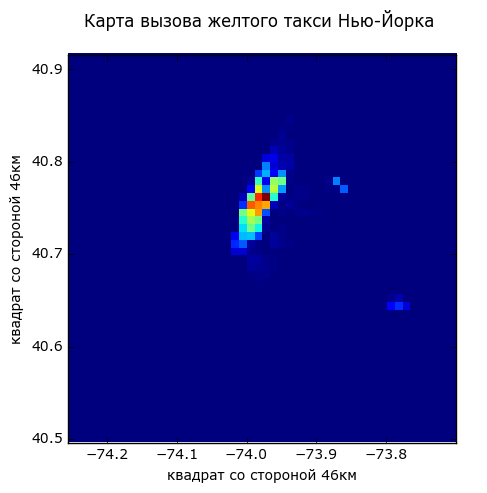

In [7]:
# Карта вызова желтого такси!
plt.figure(figsize=(5,5))
stab=plt.hist2d(x=data.pickup_longitude, y=data.pickup_latitude, bins=[xbins, ybins] )
plt.xlabel(u'квадрат со стороной 46км')
plt.ylabel(u'квадрат со стороной 46км')
plt.title(u'Карта вызова желтого такси Нью-Йорка \n')

In [8]:
del(stab)
# Жёлтое такси здесь только в центре квадрата, в Сити 

### 3.Агрегируйте данные за май 2016 года по часам и областям 

In [9]:
%%time
# Пункт 3
# Агрегируйте данные за май 2016 года по часам и областям 
# В мае 744 часа
hours_range = pd.date_range('5/1/2016', '6/1/2016', freq='H').astype('int64')
hours = len(hours_range)-1

aggr = binned_statistic_2d(x=data.region, y=data.tpep_pickup_datetime.astype('int64'), 
                          bins = [np.arange(1,2502), hours_range],
                          values=None, 
                          statistic='count', 
                          expand_binnumbers=True)

# Агрегирую в таблицу regions
for i in range(hours):
    regions['H'+str(i)] = np.ravel(aggr.statistic[:, i].astype('int64'))

Wall time: 6.72 s


In [10]:
# Проверка- в агрегированной  таблице regions поездок столько же, сколько
# в таблице data
print ('Сумма поездок в начальной таблице data: ', trip_total)
print('Сумма поездок после агрегирования: ', np.sum(regions[ [*range(5,5+hours) ]].values, dtype='int'))


Сумма поездок в начальной таблице data:  11626521
Сумма поездок после агрегирования:  11626521


### 4. Выведите первые строки полученной таблицы с указанием времени, идентификатора зоны и количества поездок.

In [11]:
# Пункт 4
# строки полученной таблицы с указанием времени, идентификатора зоны и количества поездок

regions[[0, *range(5, 5+hours) ]].head()

,region,H0,H1,H2,H3,H4,H5,H6,H7,H8,...,H734,H735,H736,H737,H738,H739,H740,H741,H742,H743
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 5. Постройте график количества поездок жёлтого такси из ячейки, содержащей Empire State Building.


In [12]:
# Коррдинаты Empire State Building
ESB_lat = 40.747778
ESB_long = -73.985833
ESB = regions[(regions.south < ESB_lat) &
                     (ESB_lat <= regions.north) &
                     (regions.west < ESB_long)  &
                     (ESB_long < regions.east) ].index


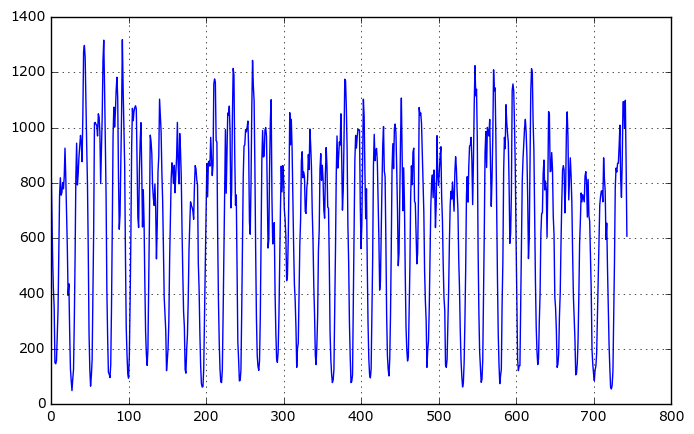

In [13]:
X = np.arange(hours)
trips = np.ravel(regions.loc[ESB])[5:]
plt.figure(figsize=(8,5))
stab=plt.plot(X, trips)
plt.grid()

### 6. Посчитайте, сколько в мае 2016 было пар час-ячейка, для которых не было совершено ни одной поездки.


In [14]:
# Пункт 6

trips = regions[[*range(5, 5+hours)]]
print('Ни одной поездки не совершено из {0} пар час-ячейка из {1}'.format( trips[trips==0].count().sum(), 2500*hours))


Ни одной поездки не совершено из 1718238 пар час-ячейка из 1860000


In [15]:
print('ответ в пункте 6 : ', trips[trips==0].count().sum())

ответ в пункте 6 :  1718238
